# Generate CMIP Future Forcing

We will generate the CMIP6 future forcing climate scenarios in this notebook, this is done because this usually takes a bit longer, and you only want to do this once.
Then you want to move onto a new notebook where you load your saved data!

We are going to need multiple things again:
- shapefile of the region of interest
- a time-window
- experiment: a certain climate scenario
- dataset
- an ensemble member
- grid

Not all CMIP climate scenarios are available on all servers.
This means that you have to carefully choose the server, **disclaimer** that means that the datasets chosen here can also be faulty.
The amount of ensemble members also vary, these are handy if you want to get a statistically better result.
Grid options define how data is spatially represented—either on the model’s native grid or a regridded format (e.g., regular lat-lon). This affects data compatibility, resolution, and comparability between models.

In [1]:
# Ignore user warnings :)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Required dependencies
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import xarray as xr
import shutil
import json
import matplotlib.pyplot as plt

import ewatercycle
import ewatercycle.forcing

First let us look at the possible datasets/ensemble members available.

In [2]:
# Read from the JSON file
with open("available_climate_datasets.json", "r") as json_file:
    loaded_dict = json.load(json_file)

# Convert lists back to sets
valid_cmip_datasets = {key: set(value) for key, value in loaded_dict.items()}
print("Valid CMIP6 datasets (as of July 2025):", valid_cmip_datasets)

Valid CMIP6 datasets (as of July 2025):
{
    'EC-Earth3-AerChem': {'r1i1p4f1', 'r3i1p1f1', 'r4i1p1f1', 'r1i1p1f1'},
    'TaiESM1': {'r1i1p1f1'},
    'AWI-ESM-1-1-LR': {'r1i1p1f1'},
    'CanESM5': {
        'r19i1p2f1',
        'r21i1p1f1',
        'r12i1p1f1',
        'r10i1p1f1',
        'r8i1p1f1',
        'r7i1p2f1',
        'r10i1p2f1',
        'r5i1p2f1',
        'r7i1p1f1',
        'r24i1p1f1',
        'r25i1p2f1',
        'r11i1p1f1',
        'r15i1p2f1',
        'r23i1p2f1',
        'r17i1p1f1',
        'r23i1p1f1',
        'r18i1p2f1',
        'r4i1p1f1',
        'r20i1p1f1',
        'r13i1p1f1',
        'r22i1p2f1',
        'r8i1p2f1',
        'r14i1p1f1',
        'r5i1p1f1',
        'r17i1p2f1',
        'r1i1p2f1',
        'r11i1p2f1',
        'r13i1p2f1',
        'r6i1p2f1',
        'r12i1p2f1',
        'r4i1p2f1',
        'r24i1p2f1',
        'r2i1p1f1',
        'r21i1p2f1',
        'r1i1p1f1',
        'r16i1p2f1',
        'r18i1p1f1',
        'r3i1p2f1',
        'r9i1p2f1',
        'r9i1p1f1',
        'r3i1p1f1',
        'r22i1p1f1',
        'r20i1p2f1',
        'r6i1p1f1',
        'r16i1p1f1',
        'r2i1p2f1',
        'r25i1p1f1',
        'r14i1p2f1',
        'r19i1p1f1',
        'r15i1p1f1'
    },
    'EC-Earth3-Veg-LR': {'r1i1p1f1'},
    'CanESM5-1': {'r1i1p2f1', 'r1i1p1f1'},
    'ACCESS-CM2': {'r5i1p1f1', 'r4i1p1f1', 'r1i1p1f1'},
    'CMCC-CM2-SR5': {
        'r11i1p2f1',
        'r7i1p2f1',
        'r6i1p2f1',
        'r10i1p2f1',
        'r4i1p2f1',
        'r5i1p2f1',
        'r2i1p2f1',
        'r8i1p2f1',
        'r1i1p1f1',
        'r3i1p2f1',
        'r9i1p2f1'
    },
    'BCC-ESM1': {'r3i1p1f1', 'r2i1p1f1', 'r1i1p1f1'},
    'FGOALS-g3': {'r6i1p1f1', 'r3i1p1f1', 'r5i1p1f1'},
    'CMCC-ESM2': {'r1i1p1f1'},
    'ACCESS-ESM1-5': {
        'r21i1p1f1',
        'r12i1p1f1',
        'r10i1p1f1',
        'r8i1p1f1',
        'r7i1p1f1',
        'r24i1p1f1',
        'r40i1p1f1',
        'r34i1p1f1',
        'r11i1p1f1',
        'r28i1p1f1',
        'r17i1p1f1',
        'r23i1p1f1',
        'r20i1p1f1',
        'r4i1p1f1',
        'r27i1p1f1',
        'r38i1p1f1',
        'r13i1p1f1',
        'r32i1p1f1',
        'r29i1p1f1',
        'r14i1p1f1',
        'r36i1p1f1',
        'r5i1p1f1',
        'r39i1p1f1',
        'r26i1p1f1',
        'r35i1p1f1',
        'r2i1p1f1',
        'r1i1p1f1',
        'r18i1p1f1',
        'r33i1p1f1',
        'r9i1p1f1',
        'r3i1p1f1',
        'r22i1p1f1',
        'r6i1p1f1',
        'r30i1p1f1',
        'r16i1p1f1',
        'r37i1p1f1',
        'r25i1p1f1',
        'r31i1p1f1',
        'r19i1p1f1',
        'r15i1p1f1'
    },
    'IITM-ESM': {'r1i1p1f1'},
    'CMCC-CM2-HR4': {'r1i1p1f1'},
    'CNRM-CM6-1': {
        'r19i1p1f2',
        'r22i1p1f2',
        'r24i1p1f2',
        'r29i1p1f2',
        'r23i1p1f2',
        'r26i1p1f2',
        'r1i1p1f2',
        'r17i1p1f2',
        'r4i1p1f2',
        'r3i1p1f2',
        'r11i1p1f2',
        'r15i1p1f2',
        'r27i1p1f2',
        'r30i1p1f2',
        'r10i1p1f2',
        'r2i1p1f2',
        'r25i1p1f2',
        'r12i1p1f2',
        'r20i1p1f2',
        'r13i1p1f2',
        'r18i1p1f2',
        'r8i1p1f2',
        'r6i1p1f2',
        'r7i1p1f2',
        'r21i1p1f2',
        'r9i1p1f2',
        'r14i1p1f2',
        'r16i1p1f2',
        'r5i1p1f2',
        'r28i1p1f2'
    },
    'CNRM-ESM2-1': {
        'r11i1p1f2',
        'r15i1p1f2',
        'r10i1p1f2',
        'r9i1p1f2',
        'r13i1p1f2',
        'r1i1p1f2',
        'r14i1p1f2',
        'r2i1p1f2',
        'r8i1p1f2',
        'r4i1p1f2',
        'r5i1p1f2',
        'r6i1p1f2',
        'r12i1p1f2',
        'r7i1p1f2',
        'r3i1p1f2'
    },
    'EC-Earth3-Veg': {'r5i1p1f1', 'r1i1p1f1'},
    'EC-Earth3': {'r12i1p1f1', 'r10i1p1f1', 'r17i1p1f1', 'r16i1p1f1', 'r14i1p1f1', 'r18i1p1f1'},
    'CNRM-CM6-1-HR': {'r1i1p1f2'}
}

So let us start with the region and the time-window + the paths we will be using:

In [3]:
# The name of the shapefile
shape_file_name = "camelsgb_33039"  # river: Bedford Ouse at Roxton, England

# The path to the shapefiles
shapefile_path =  Path.home() / "getting-started/book/some_content/forcing/shapefiles" / f"{shape_file_name}.shp"  # check this directory yourself!

# The time-window of the experiment
future_experiment_start_date = "2050-01-01T00:00:00Z"
future_experiment_end_date = "2074-12-31T00:00:00Z"

# The path save directory of the CMIP data
forcing_path_CMIP = Path.home() / "forcing" / shape_file_name / "CMIP6"   # we do not use historical here, so we can use this as a default save path later on
forcing_path_CMIP.mkdir(exist_ok=True)

## Downloading the climate scenarios
CMIP datasets can be found [here](https://aims2.llnl.gov/nodes), sometimes their servers are unreachable.
CMIP has these climate scenarios based on carbon emissions, go [here](https://climate-scenarios.canada.ca/?page=cmip6-overview-notes) (or [here](https://www.dkrz.de/en/communication/climate-simulations/cmip6-en/the-ssp-scenarios)) to find out more!
Here I set up SSP1, 2 and 5:

- **SSP1**: The sustainable and “green” pathway describes an increasingly sustainable world. Global commons are being preserved, the limits of nature are being respected. The focus is more on human well-being than on economic growth. Income inequalities between states and within states are being reduced. Consumption is oriented towards minimizing material resource and energy usage.

- **SSP2**: The “Middle of the road” or medium pathway extrapolates the past and current global development into the future. Income trends in different countries are diverging significantly. There is a certain cooperation between states, but it is barely expanded. Global population growth is moderate, leveling off in the second half of the century. Environmental systems are facing a certain degradation.

- **SSP3**: Regional rivalry. A revival of nationalism and regional conflicts pushes global issues into the background. Policies increasingly focus on questions of national and regional security. Investments in education and technological development are decreasing. Inequality is rising. Some regions suffer drastic environmental damage.

- **SSP4**: Inequality. The chasm between globally cooperating developed societies and those stalling at a lower developmental stage with low income and a low level of education is widening. Environmental policies are successful in tackling local problems in some regions, but not in others.

- **SSP5**: Fossil-fueled Development. Global markets are increasingly integrated, leading to innovations and technological progress. The social and economic development, however, is based on an intensified exploitation of fossil fuel resources with a high percentage of coal and an energy-intensive lifestyle worldwide. The world economy is growing and local environmental problems such as air pollution are being tackled successfully.

The numbers behind the SSP1xx mean extra radiative forcing of $x.x$ $W/m^2$ by the year 2100. They come in at $1.9$, $2.6$, $3.4$, $4.5$, $6.0$, $7.0$ and $8.5$ $W/m^2$, more [*info*](https://www.dkrz.de/en/communication/climate-simulations/cmip6-en/the-ssp-scenarios).

It is also possible to pick just one scenario and use different ensembles to reach a statistically better result!

Since we are saving it to their respective folder we only have to run the data gathering **ONCE**.
As you will notice it will take a longer time to gather the forcing data.
After this gathering we will just be using the saved files, which should be done in a separate notebook, but is done in this notebook for the sake of simplicity.

In [4]:
# ONLY RUN THIS ONCE
# DO this for every experiment you want to do!

# Generate SSP126 data and save it in the correct directory
cmip_dataset =  {
   'project': 'CMIP6',
   'activity': 'ScenarioMIP',
   'exp': 'ssp126',
   'mip': 'day',
   'dataset': 'MPI-ESM1-2-HR',
   'ensemble': 'r1i1p1f1',
   'institute': 'DKRZ',
   'grid': 'gn'
}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=cmip_dataset,
   start_time=future_experiment_start_date,
   end_time=future_experiment_end_date,
   shape=shapefile_path,
   directory=forcing_path_CMIP / "SSP126",
)

# Generate SSP245 data and save it in the correct directory
cmip_dataset =  {
   'project': 'CMIP6',
   'activity': 'ScenarioMIP',
   'exp': 'ssp245',
   'mip': 'day',
   'dataset': 'MPI-ESM1-2-HR',
   'ensemble': 'r1i1p1f1',
   'institute': 'DKRZ',
   'grid': 'gn'
}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=cmip_dataset,
   start_time=future_experiment_start_date,
   end_time=future_experiment_end_date,
   shape=shapefile_path,
   directory=forcing_path_CMIP / "SSP245",
)

# Generate SSP585 data and save it in the correct directory
cmip_dataset =  {
   'project': 'CMIP6',
   'activity': 'ScenarioMIP',
   'exp': 'ssp585',
   'mip': 'day',
   'dataset': 'MPI-ESM1-2-HR',
   'ensemble': 'r1i1p1f1',
   'institute': 'DKRZ',
   'grid': 'gn'
}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=cmip_dataset,
   start_time=future_experiment_start_date,
   end_time=future_experiment_end_date,
   shape=shapefile_path,
   directory=forcing_path_CMIP / "SSP585",
)

Normally you can look at the cmip forcing now, but we will first show you how to load the data and move on from there:


In [5]:
# Load the generated SSP126 data
ssp126_location = forcing_path_CMIP / "SSP126" / "work" / "diagnostic" / "script"
SSP126_CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp126_location)

# Load the generated SSP245 data
ssp245_location = forcing_path_CMIP / "SSP245" / "work" / "diagnostic" / "script"
SSP245_CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp245_location)

# Load the generated SSP585 data
ssp585_location = forcing_path_CMIP / "SSP585" / "work" / "diagnostic" / "script"
SSP585_CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=ssp585_location)

In [6]:
print(SSP126_CMIP_forcing)

print(SSP245_CMIP_forcing)

print(SSP585_CMIP_forcing)

LumpedMakkinkForcing(
    start_time='2050-01-01T00:00:00Z',
    end_time='2074-12-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/forcing/camelsgb_33039/CMIP6/SSP126/work/diagnostic/script'),
    shape=PosixPath('/home/mmelotto/forcing/camelsgb_33039/CMIP6/SSP126/work/diagnostic/script/camelsgb_33039.shp')
,
    filenames={
        'pr': 'CMIP6_MPI-ESM1-2-HR_day_ssp126_r1i1p1f1_pr_gn_2050-2074.nc',
        'tas': 'CMIP6_MPI-ESM1-2-HR_day_ssp126_r1i1p1f1_tas_gn_2050-2074.nc',
        'rsds': 'CMIP6_MPI-ESM1-2-HR_day_ssp126_r1i1p1f1_rsds_gn_2050-2074.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

LumpedMakkinkForcing(
    start_time='2050-01-01T00:00:00Z',
    end_time='2074-12-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/forcing/camelsgb_33039/CMIP6/SSP245/work/diagnostic/script'),
    shape=PosixPath('/home/mmelotto/forcing/camelsgb_33039/CMIP6/SSP245/work/diagnostic/script/camelsgb_33039.shp')
,
    filenames={
        'pr': 'CMIP6_MPI-ESM1-2-HR_day_ssp245_r1i1p1f1_pr_gn_2050-2074.nc',
        'tas': 'CMIP6_MPI-ESM1-2-HR_day_ssp245_r1i1p1f1_tas_gn_2050-2074.nc',
        'rsds': 'CMIP6_MPI-ESM1-2-HR_day_ssp245_r1i1p1f1_rsds_gn_2050-2074.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

LumpedMakkinkForcing(
    start_time='2050-01-01T00:00:00Z',
    end_time='2074-12-31T00:00:00Z',
    directory=PosixPath('/home/mmelotto/forcing/camelsgb_33039/CMIP6/SSP585/work/diagnostic/script'),
    shape=PosixPath('/home/mmelotto/forcing/camelsgb_33039/CMIP6/SSP585/work/diagnostic/script/camelsgb_33039.shp')
,
    filenames={
        'pr': 'CMIP6_MPI-ESM1-2-HR_day_ssp585_r1i1p1f1_pr_gn_2050-2074.nc',
        'tas': 'CMIP6_MPI-ESM1-2-HR_day_ssp585_r1i1p1f1_tas_gn_2050-2074.nc',
        'rsds': 'CMIP6_MPI-ESM1-2-HR_day_ssp585_r1i1p1f1_rsds_gn_2050-2074.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

So the LumpedMakkinkForcing stores the following:
1. pr: precipitation
2. tas: temperature
3. rsds: incoming shortwave radiation
4. evspsblpot: potential evaporation (note that this is calculated, using Makkink)

## The data

We can 'easily' plot the data now!

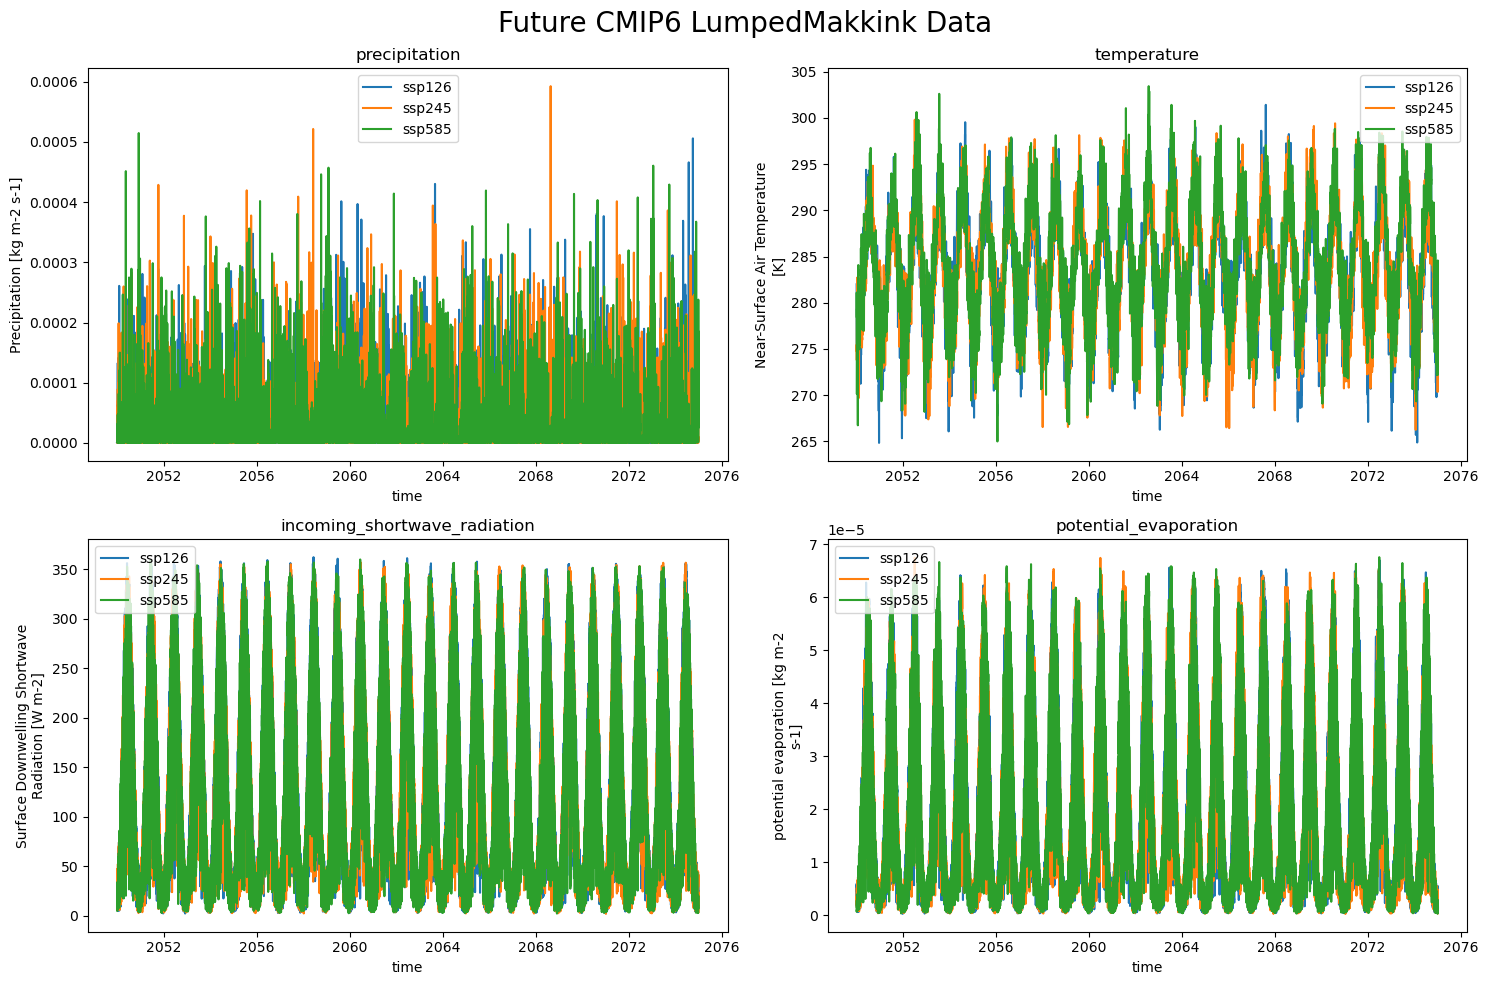

In [7]:
all_CMIP_data = {'ssp126': {'precipitation pr': xr.open_dataset(SSP126_CMIP_forcing['pr']),
                            'temperature tas': xr.open_dataset(SSP126_CMIP_forcing['tas']),
                            'incoming_shortwave_radiation rsds': xr.open_dataset(SSP126_CMIP_forcing['rsds']),
                            'potential_evaporation evspsblpot': xr.open_dataset(SSP126_CMIP_forcing['evspsblpot'])
                            },
                 'ssp245': {'precipitation pr': xr.open_dataset(SSP245_CMIP_forcing['pr']),
                            'temperature tas': xr.open_dataset(SSP245_CMIP_forcing['tas']),
                            'incoming_shortwave_radiation rsds': xr.open_dataset(SSP245_CMIP_forcing['rsds']),
                            'potential_evaporation evspsblpot': xr.open_dataset(SSP245_CMIP_forcing['evspsblpot'])
                            },
                'ssp585': {'precipitation pr': xr.open_dataset(SSP585_CMIP_forcing['pr']),
                            'temperature tas': xr.open_dataset(SSP585_CMIP_forcing['tas']),
                            'incoming_shortwave_radiation rsds': xr.open_dataset(SSP585_CMIP_forcing['rsds']),
                            'potential_evaporation evspsblpot': xr.open_dataset(SSP585_CMIP_forcing['evspsblpot'])
                            }
}

plot_counter = 1
plt.figure(figsize=(15, 10))
for climate_scenario, all_data in all_CMIP_data.items():
    for name, data in all_CMIP_data[climate_scenario].items():
        plt.subplot(2,2, plot_counter)
        data[name.split(" ")[-1]].plot(label=climate_scenario)
        plt.title(f"{name.split(" ")[0]}")
        plt.legend()
        plot_counter += 1

    plot_counter = 1

plt.suptitle("Future CMIP6 LumpedMakkink Data", fontsize=20)
plt.tight_layout()